In [1]:
#Import pandas, matplotlib.pyplot, and seaborn in the correct lines below
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

In [3]:
df_user = pd.read_csv("/Users/angelique/Documents/GitHub/relax_challenge/Relax_inc/takehome_users.csv", encoding='ISO-8859-1')
df_eng = pd.read_csv("/Users/angelique/Documents/GitHub/relax_challenge/Relax_inc/takehome_user_engagement.csv", parse_dates=["time_stamp"])

In [5]:
df_eng.head()

,time_stamp,user_id,visited
0,2014-04-22 03:53:30,1,1
1,2013-11-15 03:45:04,2,1
2,2013-11-29 03:45:04,2,1
3,2013-12-09 03:45:04,2,1
4,2013-12-25 03:45:04,2,1


In [7]:
# Function to check if a user meets the adoption criteria (3 or more distinct days in a 7-day window)
def check_adoption(df_date, users):
    adoption_status = []
    for i in users:
        id_filter = df_date["user_id"] == i
        df_filter = df_date[id_filter].resample("1D")["user_id"].nunique()  # Count distinct days visited
        df_filter = df_filter.rolling(window=7).sum()  # Sum of distinct days within a 7-day window
        df_filter = df_filter.dropna()
        adoption_status.append(any(df_filter >= 3))  # True if any window has 3 or more distinct days
    return adoption_status

# Step 1: Prepare the data
df_date = df_eng.set_index("time_stamp")
users = df_date["user_id"].unique()

# Step 2: Check for 'adopted_user' status
adopted_user = check_adoption(df_date, users)

# Create a DataFrame with the adoption status for each user
adopted_df = pd.DataFrame({'user_id': users, 'adopted_user': adopted_user})

# Step 3: Convert 'adopted_user' to 0 or 1
adopted_df['adopted_user'] = adopted_df['adopted_user'].astype(int)

# Step 4: Create the 'is_in_users' column (whether the user is in the users list)
df_eng['is_in_users'] = df_eng['user_id'].isin(users).astype(int)  # Encode as 1 or 0

# Step 5: Merge adoption data with df_user for additional user info
df_user.rename(columns={'object_id': 'user_id'}, inplace=True)  # Ensure 'user_id' column is named correctly

# Merge adoption data with df_user
df = pd.merge(adopted_df, df_user[['user_id', 'creation_source', 'creation_time', 
                                   'opted_in_to_mailing_list', 'enabled_for_marketing_drip', 
                                   'invited_by_user_id']], on='user_id', how='left')

# Show the new DataFrame
df.head()


,user_id,adopted_user,creation_source,creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,invited_by_user_id
0,1,0,GUEST_INVITE,2014-04-22 03:53:30,1,0,10803.0
1,2,1,ORG_INVITE,2013-11-15 03:45:04,0,0,316.0
2,3,0,ORG_INVITE,2013-03-19 23:14:52,0,0,1525.0
3,4,0,GUEST_INVITE,2013-05-21 08:09:28,0,0,5151.0
4,5,0,GUEST_INVITE,2013-01-17 10:14:20,0,0,5240.0


In [8]:
def plot_binary_distribution(df, column, xlabel='', title='', percentage=False):
    """Plots a binary categorical distribution with an option to show percentages."""
    
    # Count occurrences (with percentage option)
    counts = df[column].value_counts(normalize=percentage) * (100 if percentage else 1)
    
    # Create the bar plot
    ax = sns.barplot(x=counts.index, y=counts.values, order=[0, 1])

    # Add labels directly
    ax.bar_label(ax.containers[0], fmt='%.2f%%' if percentage else '%d')

    # Customize the plot
    plt.xlabel(xlabel)
    plt.ylabel('Percentage' if percentage else 'Number of Customers')
    plt.title(title)
    
    # Show the plot
    plt.show()

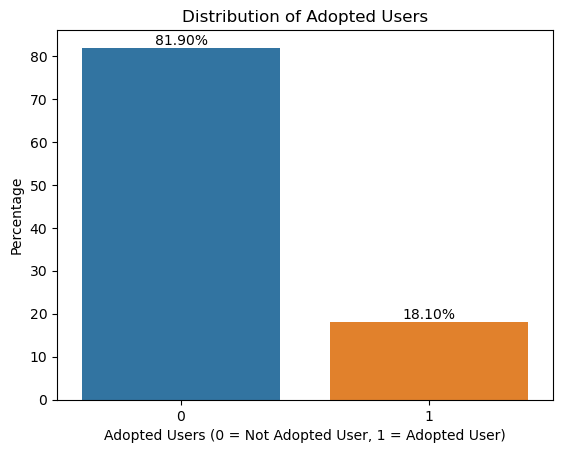

In [43]:
#look at the raw distribution of Adopted Customers
plot_binary_distribution(df, 'adopted_user', xlabel='Adopted Users (0 = Not Adopted User, 1 = Adopted User)', title='Distribution of Adopted Users', percentage=True)

In [13]:
def dataframe_summary(df, mode="nan"):
    """Returns a summary of NaN counts, unique values, or non-NaN counts based on the mode.
    
    Parameters:
    df (pd.DataFrame): The DataFrame to analyze.
    mode (str): The operation to perform. Options:
                - "nan": Count of NaN values per column.
                - "unique": Count of unique values per column.
                - "notna": Count of non-NaN values per column.
    
    Returns:
    pd.Series: The result of the chosen operation.
    """
    if mode == "nan":
        return df.isna().sum()
    elif mode == "unique":
        return df.nunique()
    elif mode == "notna":
        return df.notna().sum()
    else:
        raise ValueError("Invalid mode. Choose from 'nan', 'unique', or 'notna'.")

In [15]:
import numpy as np
import datetime

# Ensure 'creation_time' is in datetime format
df['creation_time'] = pd.to_datetime(df['creation_time'], errors='coerce')  # Convert to datetime, coercing errors to NaT

# See if there's seasonality in creation_time for adopted_users by separating out year and month then drop creation_time
df['Year'] = df['creation_time'].dt.year
df['Month'] = df['creation_time'].dt.month

# Replace invited_by_user_id as invited_by_user then drop invited_by_user_id
df['invited_by_user'] = np.where(df['invited_by_user_id'].isna(), 0, 1)

# Drop columns we don't need anymore: creation_time, invited_by_user_id, and user_id
df.drop(columns=['creation_time', 'invited_by_user_id', 'user_id'], inplace=True)

# Summarize the dataframe to check for missing values or other insights
dataframe_summary(df, mode='nan')

adopted_user                  0
creation_source               0
opted_in_to_mailing_list      0
enabled_for_marketing_drip    0
Year                          0
Month                         0
invited_by_user               0
dtype: int64

In [17]:
from sklearn import __version__ as sklearn_version
from sklearn.decomposition import PCA
from sklearn.preprocessing import scale
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.dummy import DummyRegressor
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.feature_selection import SelectKBest, f_regression
from imblearn.over_sampling import SMOTE

df = pd.get_dummies(df, columns=['creation_source'], drop_first=False)
df.head()

,adopted_user,opted_in_to_mailing_list,enabled_for_marketing_drip,Year,Month,invited_by_user,creation_source_GUEST_INVITE,creation_source_ORG_INVITE,creation_source_PERSONAL_PROJECTS,creation_source_SIGNUP,creation_source_SIGNUP_GOOGLE_AUTH
0,0,1,0,2014,4,1,True,False,False,False,False
1,1,0,0,2013,11,1,False,True,False,False,False
2,0,0,0,2013,3,1,False,True,False,False,False
3,0,0,0,2013,5,1,True,False,False,False,False
4,0,0,0,2013,1,1,True,False,False,False,False


In [19]:
# creation_source dummies are showing as boolean, switch to integer using the function below
def convert_booleans_to_integers(df):
    # Loop through columns and convert those with boolean dtype to integers
    for column in df.select_dtypes(include='bool').columns:
        df[column] = df[column].astype(int)
    return df

# Use new function
df = convert_booleans_to_integers(df)

# Check the first few rows to see the change
df.head()

,adopted_user,opted_in_to_mailing_list,enabled_for_marketing_drip,Year,Month,invited_by_user,creation_source_GUEST_INVITE,creation_source_ORG_INVITE,creation_source_PERSONAL_PROJECTS,creation_source_SIGNUP,creation_source_SIGNUP_GOOGLE_AUTH
0,0,1,0,2014,4,1,1,0,0,0,0
1,1,0,0,2013,11,1,0,1,0,0,0
2,0,0,0,2013,3,1,0,1,0,0,0
3,0,0,0,2013,5,1,1,0,0,0,0
4,0,0,0,2013,1,1,1,0,0,0,0


In [21]:
from sklearn.model_selection import train_test_split, cross_validate, GridSearchCV, learning_curve
from sklearn.metrics import classification_report, confusion_matrix,recall_score , accuracy_score, precision_score, roc_auc_score

X = df.drop(columns=['adopted_user'])
y = df['adopted_user']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale Data 
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


In [25]:
from sklearn.metrics import make_scorer, f1_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV

# Hyperparameter grid
param_dist = {
    'n_estimators': np.arange(100, 1001, 100),  # 100, 200, ..., 1000
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2'],
    'bootstrap': [True, False]
}

# Initialize RandomForestClassifier
rf = RandomForestClassifier(random_state=88)

# RandomizedSearchCV initialization
random_search = RandomizedSearchCV(
    estimator=rf, 
    param_distributions=param_dist, 
    n_iter=20,  # Reduce number of iterations
    cv=5,  
    n_jobs=1,  # Use only 1 job (prevents crashes)
    verbose=1,  
    random_state=88
)

# Fit the model
random_search.fit(X_train_scaled, y_train)

# Output the best parameters and the best score
print("Best Parameters:", random_search.best_params_)  # note the underscore
print("Best F1 Score:", random_search.best_score_)

Fitting 5 folds for each of 20 candidates, totalling 100 fits
Best Parameters: {'n_estimators': 500, 'min_samples_split': 5, 'min_samples_leaf': 4, 'max_features': 'sqrt', 'max_depth': 10, 'bootstrap': True}
Best F1 Score: 0.8211956641764525


In [27]:
from sklearn.ensemble import RandomForestClassifier

best_params = random_search.best_params_

# Initialize the Random Forest classifier with the best parameters
rf = RandomForestClassifier(
    n_estimators=best_params['n_estimators'],
    min_samples_split=best_params['min_samples_split'],
    min_samples_leaf=best_params['min_samples_leaf'],
    max_features=best_params['max_features'],
    max_depth=best_params['max_depth'],
    bootstrap=best_params['bootstrap']
)

In [29]:
# Fit the model
rf.fit(X_train_scaled,y_train)

RandomForestClassifier(max_depth=10, min_samples_leaf=4, min_samples_split=5,
                       n_estimators=500)

In [45]:
y_pred_rf = rf.predict(X_test_scaled)
accuracy = accuracy_score(y_test, y_pred_rf)
print('The Accuracy for this model is ' + str(accuracy))

The Accuracy for this model is 0.8084985835694051


In [41]:
# Get feature importance from the best estimator
feature_importance = random_search.best_estimator_.feature_importances_

# If X_train_scaled is an array, retrieve feature names from the original DataFrame
feature_names = X_train.columns if isinstance(X_train, pd.DataFrame) else [f'Feature {i}' for i in range(X_train_scaled.shape[1])]

# Create a DataFrame
features_df = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importance})
features_df = features_df.sort_values(by='Importance', ascending=False)

# Display top features
print(features_df.head(10))  # Show top 10 most important features

                              Feature  Importance
3                               Month    0.574585
2                                Year    0.168276
0            opted_in_to_mailing_list    0.077483
1          enabled_for_marketing_drip    0.068337
5        creation_source_GUEST_INVITE    0.026829
8              creation_source_SIGNUP    0.019744
9  creation_source_SIGNUP_GOOGLE_AUTH    0.017892
7   creation_source_PERSONAL_PROJECTS    0.017463
6          creation_source_ORG_INVITE    0.015960
4                     invited_by_user    0.013430


# **Summary 
Based on the feature importance results, the strongest predictors of user adoption are whether a client opted into the mailing list and whether they are enabled for marketing drip campaigns. These factors appear to have the most significant correlation with predicting user adoption.

Following that, the "creation_source" features, such as the various signup and invitation methods, rank as secondary predictors of adoption. Notably, "invited_by_user" seems to have the least predictive power in this context, with a relatively low importance score.

One consideration regarding the model’s accuracy is the class imbalance in the dataset, where only about 18% of users are marked as adopted. Despite this imbalance, the Random Forest model is still performing well, with an F1 score of 81.12%. This indicates that the model is doing a good job at balancing precision and recall, even in the presence of class imbalance.

The feature "Month" stands out as the most important predictor, suggesting a seasonal trend in user adoption. Given its high correlation with adoption, it could be valuable for Relax Inc. to target marketing efforts at specific times of the year when adoption rates are higher.